In [1]:
import numpy as np
import pandas as pd

column_names = ["label", "ids", "date", "flag", "user", "tweet"]
df = pd.read_csv('data.csv', encoding="ISO-8859-1", names=column_names)

In [2]:
df.head()

,label,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
del df['ids'], df['date'], df['flag'], df['user']
df = df[['tweet', 'label']]
df['label'] = (df['label'] > 0).astype(np.int8)

In [4]:
df.head()

,tweet,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [5]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
VOCAB_SIZE = 20000
OOV_TOKEN = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

In [7]:
tokenizer.fit_on_texts(X_train)

In [8]:
import json

tokenizer_data = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(json.dumps(tokenizer_data,ensure_ascii=False))


In [9]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
MAX_LEN_train = max(len(seq) for seq in X_train)
MAX_LEN_test = max(len(seq) for seq in X_test)
MAX_LEN = max(MAX_LEN_train, MAX_LEN_test)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

EMBEDDING_DIM = 16

ann = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = ann.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Train on 1280000 samples, validate on 320000 samples
Epoch 1/10
1280000/1280000 [==============================] - 237s 185us/sample - loss: 0.4477 - accuracy: 0.7897 - val_loss: 0.4315 - val_accuracy: 0.7978
Epoch 2/10
1280000/1280000 [==============================] - 232s 181us/sample - loss: 0.4224 - accuracy: 0.8052 - val_loss: 0.4196 - val_accuracy: 0.8071
Epoch 3/10
1280000/1280000 [==============================] - 233s 182us/sample - loss: 0.4132 - accuracy: 0.8107 - val_loss: 0.4240 - val_accuracy: 0.8057
Epoch 4/10
1280000/1280000 [==============================] - 232s 181us/sample - loss: 0.4063 - accuracy: 0.8142 - val_loss: 0.4158 - val_accuracy: 0.8089
Epoch 5/10
1280000/1280000 [==============================] - 233s 182us/sample - loss: 0.4005 - accuracy: 0.8177 - val_loss: 0.4175 - val_accuracy: 0.8079
Epoch 6/10
1280000/1280000 [==============================] - 230s 180us/sample - loss: 0.3958 - accuracy: 0.8198 - val_loss: 0.4158 - val_accuracy: 0.8092
Epoch 7/10


In [14]:
ann.save('model.h5')

In [15]:
import matplotlib.pyplot as plt

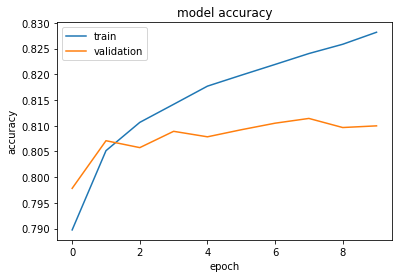

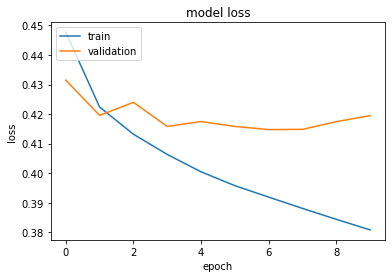

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()